# Train model

In [1]:
batch_size=32
pickle_file='test_dataset_cluster_labeled.pickle'
limit_seq_len=1000

In [2]:
from dataset import DwgDataset
dwg_dataset = DwgDataset(pickle_file=pickle_file, batch_size=batch_size, limit_seq_len=limit_seq_len)

In [3]:
lr=0.0001
epochs=50
train_verbose=True

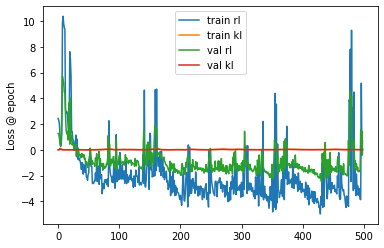

D:\py\dwg-crawl\JupyterNotebooks\sketch_rnn.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0, 1).squeeze()).view(len_out, -1, self.M)
D:\py\dwg-crawl\JupyterNotebooks\sketch_rnn.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out, -1, no_logits)


  [ 499-   0 @   0.9 sec] RLoss: -0.95989 KL Loss: 0.0287
  [ 499-   1 @   1.7 sec] RLoss: 0.06978 KL Loss: 0.0289
Epoch [499 @  1.9] validation losses rl:-1.5859 kl:0.0162
Test losses rl:0.0086 kl:-0.9586


In [4]:
from sketch_rnn import Trainer
from IPython.display import clear_output
from plot_graphics import plot_history

trainer = Trainer(
    dwg_dataset, 
    lr=lr, 
    train_verbose=train_verbose)

train_kl_losses = []
train_rl_losses = []
val_kl_losses  = []
val_rl_losses  = []

for epoch in range(epochs):
    clear_output(wait=True)
    
    plot_history(train_rl_losses, train_kl_losses, val_rl_losses, val_kl_losses)
    test_rl, test_kl, val_rl, val_kl = trainer.train_epoch(epoch)
    
    train_kl_losses.append(test_kl)
    train_rl_losses.append(test_rl)
    val_kl_losses.append(val_kl)
    val_rl_losses.append(val_rl)

# Calculate test accuracy
test_kl, test_rl = trainer.CalculateLoaderAccuracy(trainer.test_loader)
print('Test losses rl:{:1.4f} kl:{:1.4f}'.format(test_rl, test_kl))    

# Evaluate model

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [5]:
stroke_features = dwg_dataset.entities.stroke_features
max_seq_length = dwg_dataset.entities.max_seq_length

enc_hidden_size    = 256
dec_hidden_size    = 512

d_z=128
n_distributions    = 20

from model import DecoderRNN, EncoderRNN
encoder = EncoderRNN(d_z, enc_hidden_size, stroke_features=stroke_features)
decoder = DecoderRNN(d_z, dec_hidden_size, n_distributions, stroke_features=stroke_features)
encoder.to(device)
decoder.to(device)

# https://pytorch.org/tutorials/beginner/saving_loading_models.html
encoder.load_state_dict(torch.load('DimEncoder.model', map_location=device))
decoder.load_state_dict(torch.load('DimDecoder.model', map_location=device))

decoder.eval()
encoder.eval()

NameError: name 'device' is not defined

In [ ]:
import drawSvg as draw
from plot_graphics  import images_from_batch

In [ ]:
from IPython.display import Image
from IPython.display import clear_output

In [ ]:
for i, batch in enumerate(dwg_dataset.train_loader):
    
    data = batch[0].to(device).transpose(0, 1)
    mask = batch[1].to(device).transpose(0, 1)
    
    for i in images_from_batch(data):
        display(i)
    #sampler = Sampler(encoder, decoder)
    #seq = sampler.sample(data, 0.4)
    #print(seq)
    break